### Image classifier

<br>

##### Importng the nessecary modules

In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use(['dark_background'])

<br>


##### Read any particular celeb image using cv2

In [4]:
img = cv2.imread(r".\dataset\dwayne_johnson\8b69e06e1b8048bab8d39c1a9eed440a.jpg")
img.shape    ## returns x, y, rbg

(1440, 2560, 3)

<br>

Plotting the image using cv2

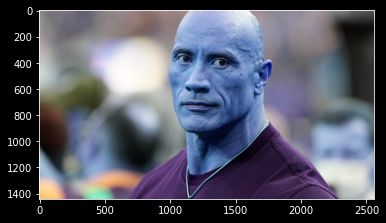

In [5]:
plt.imshow(img)

<br>

Plotting the image in gray

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape ## removes the rbg parameter making it a gray img

(1440, 2560)

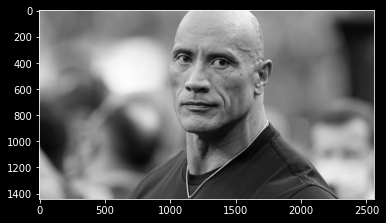

In [7]:
plt.imshow(gray, cmap="gray")

<br>

Using the cv2 we will detect the face in this above picture

In [8]:
# loading the haar cascade file for face and eye
face_cascade = cv2.CascadeClassifier(r".\opencv\haarcascades\haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(r".\opencv\haarcascades\haarcascade_eye.xml")


faces =  face_cascade.detectMultiScale(gray, 1.3, 5)
faces ## returns x, y, width, heigth

array([[799,  34, 890, 890]])

In [9]:
(x, y, w, h) = faces[0]
x, y, w, h

(799, 34, 890, 890)

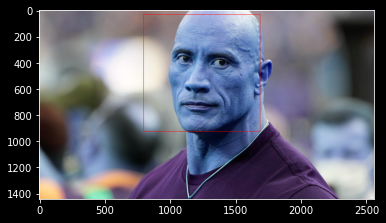

In [10]:
# detecting the face
face_detect = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(face_detect)

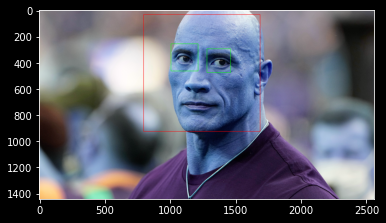

In [11]:
# detecting the face with eye

cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<br>

Getting the cropped image of the face and eye

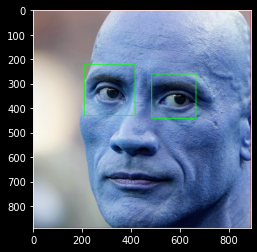

In [12]:
plt.imshow(roi_color, cmap='gray')

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(890, 890, 3)

<br><br>

#### Data cleaning

<br>

Preprocessing use wavelet transform as a feature for traning our model

In [14]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

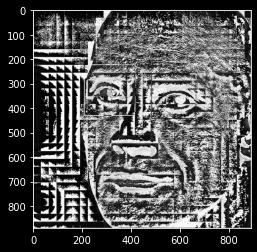

In [15]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<br>
<br>

Defining a fuction which will return the cropped face image if it detects a face with two eyes

In [16]:
def crop_img2eye(img_url):
    try:
        img = cv2.imread(img_url)    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color    
    except:
        print("\nAn error occured...🤔")
        return None

<br><br><br><br><br>

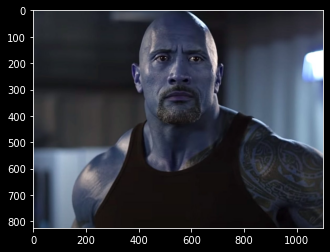

In [17]:
url = r".\dataset\dwayne_johnson\60c9ff9020bd1300181c67f1.jpeg"
img_data = cv2.imread(url)
plt.imshow(img_data)

In [19]:
data = crop_img2eye(url)

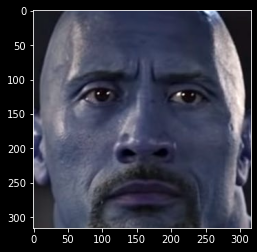

In [20]:
if data is not None:
    plt.imshow(data)

Scanning the directory of dataset

In [21]:
path_to_data = "./dataset/"
path_to_crop_data = "./dataset/cropped/"

In [22]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
img_dirs

['./dataset/dwayne_johnson',
 './dataset/gong_yoo',
 './dataset/kevin_hart',
 './dataset/kim_so_hyun']

<br>

Checking the directory of dataset/cropped exist or not if exits then replace it with a new one or if not exists then create a new one

In [24]:
import shutil
if os.path.exists(path_to_crop_data):
     shutil.rmtree(path_to_crop_data)
os.mkdir(path_to_crop_data)

<br><br>
Now, we will take these img directory split it into an array from where we will get our celeb names, scan the images from the particular directories of that celeb name. 
<br>

Call the _crop_img2eye_ fn to return the cropped image and save it in the specificed celeb name folder inside the cropped folder

In [25]:
crop_img_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celeb_name = img_dir.split("/")[-1]
    celebrity_file_names_dict[celeb_name] = []
    
    for entry in os.scandir(img_dir):
        entry_url = entry.path
        
        roi_color = crop_img2eye(entry_url)
        if roi_color is not None:
            crop_folder = path_to_crop_data + celeb_name
            if not os.path.exists(crop_folder):
                print("Generating cropped images folders:", crop_folder)
                os.makedirs(crop_folder)
                crop_img_dirs.append(crop_folder)
                
                
            crop_file_name = celeb_name + str(count) + ".png"
            crop_file_path = crop_folder + "/" + crop_file_name

            cv2.imwrite(crop_file_path, roi_color)
            celebrity_file_names_dict[celeb_name].append(crop_file_path)
            count+=1
print("\nSuccesfully Completed! 😊")

Generating cropped images folders: ./dataset/cropped/dwayne_johnson

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔
Generating cropped images folders: ./dataset/cropped/gong_yoo

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔
Generating cropped images folders: ./dataset/cropped/kevin_hart

An error occured...🤔
Generating cropped images folders: ./dataset/cropped/kim_so_hyun

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

An error occured...🤔

Succesfully Completed! 😊


In [26]:
celebrity_file_names_dict = {}
for img_dir in crop_img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
# celebrity_file_names_dict

<br>
Just assigning a number to the celeb names

In [28]:
celeb_num = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    celeb_num[celebrity_name] = count
    count = count + 1
celeb_num

{'dwayne_johnson': 0, 'gong_yoo': 1, 'kevin_hart': 2, 'kim_so_hyun': 3}

<br>
Taking the celeb name dict we will read the cropped raw images and scale them into 32*32 also transform the image using wavelet transformation and reshpe it.
<br><br>
Later, combine both of the one after another into a single image.
Then split it into X, y

In [29]:
X, y = [], []

for celeb_name, celeb_img_path in celebrity_file_names_dict.items():
    for training_img in celeb_img_path:
        img = cv2.imread(training_img)
        if img is None:
            continue        
        scaled_img_raw = cv2.resize(img, (32, 32))
        img_har = w2d(scaled_img_raw, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scaled_img_raw.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(celeb_num[celeb_name])

In [30]:
len(X)

398

In [31]:
len(X[0])

4096

<br>
Just coverting X into float to train model so that we don't get error warning from sklearn

In [32]:
X = np.array(X).reshape(len(X), len(X[0])).astype(float)
X.shape

(398, 4096)

In [33]:
len(X[1])

4096

In [34]:
X

array([[164., 146., 147., ...,  56.,  62., 180.],
       [ 16.,  16.,  16., ..., 244., 246.,  83.],
       [ 84.,  87.,  91., ...,  52.,  50.,  49.],
       ...,
       [184.,  54.,  55., ..., 178., 206., 176.],
       [ 87., 131., 175., ..., 188., 189., 186.],
       [187., 178., 177., ..., 190., 218., 173.]])

In [35]:
X[0]

array([164., 146., 147., ...,  56.,  62., 180.])

<br><br>

#### Train our model

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [37]:
# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel="rbf", C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.97

In [39]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.92      1.00      0.96        23
           2       1.00      0.94      0.97        17
           3       1.00      0.97      0.98        31

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



<br>
Using GridSearchCV for HyperParamter tuning the parameters of the models

In [40]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [41]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [43]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.919153,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.788588,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.926215,{'logisticregression__C': 5}


In [44]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [45]:
best_estimators['svm'].score(X_test,y_test)

0.96

In [46]:
best_estimators['random_forest'].score(X_test,y_test)

0.81

In [47]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.93

In [56]:
best_clf = best_estimators['logistic_regression']

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[27,  1,  1,  0],
       [ 0, 21,  1,  1],
       [ 2,  0, 15,  0],
       [ 0,  1,  0, 30]], dtype=int64)

Text(33.0, 0.5, 'Actual Values')

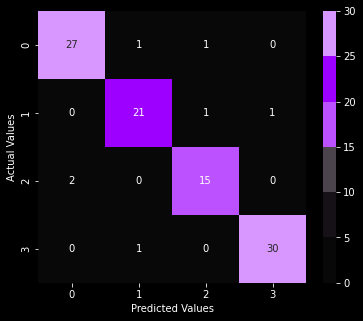

In [58]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6, 5)

colormap = sns.color_palette(["#080808", "#151116", "#4b444d", "#bc51ff", "#9d00ff", "#d797ff"])
sns.heatmap(cm, cmap=colormap, annot=True)

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

In [59]:
celeb_num

{'dwayne_johnson': 0, 'gong_yoo': 1, 'kevin_hart': 2, 'kim_so_hyun': 3}

<br>

#### Save the trained model

In [60]:
import joblib

# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

<br>

#### Save the celebrity names dictionary for later use

In [61]:
import json

with open('celeb_nameMap.json', "w") as f:
    f.write(json.dumps(celeb_num))